In [1]:
import os
import joblib
import pandas as pd
import torch
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import support.download_data
import support.load_data

path_to_data = "support/data"

## optional random seed
SEED = 42
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

# Download the dataset

Download the dataset if it is not already present in the specified path.

In [ ]:
# support.download_data.download_and_extract_zip(path_to_data) # uncomment to download the dataset

# Load Dataset

Call the custom loader to load the images into a torch.DataLoader object. 

In [54]:
mode='rgb'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5] * (3 if mode == 'rgb' else 1),
        std=[0.5] * (3 if mode == 'rgb' else 1)
    )
])

batch_size = 32

train_loader, test_loader, train_dataset, test_dataset = support.load_data.load_dataset(
    path_to_data, transform=transform, batch_size=batch_size)


# Setup and train model
## Setup resnet50 model for feature extraction

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
def extract_features(dataloader, description="Extracting features"):
    features = []
    labels = []
    total_batches = len(dataloader)
    print(f"{description} ({total_batches} batches):")
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dataloader, start=1):
            images = images.to(device)
            outputs = resnet50(images)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
            if batch_idx % 10 == 0 or batch_idx == total_batches:
                print(f"Processed {batch_idx}/{total_batches} batches...")
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [8]:
X_train, y_train = extract_features(train_loader, description="Training set feature extraction")
X_test, y_test = extract_features(test_loader, description="Test set feature extraction")

Training set feature extraction (44 batches):
Processed 10/44 batches...
Processed 20/44 batches...
Processed 30/44 batches...
Processed 40/44 batches...
Processed 44/44 batches...
Test set feature extraction (8 batches):
Processed 8/8 batches...


In [10]:
svm_model = SVC(kernel='linear', C=1.0, random_state=SEED, verbose=True)
svm_model.fit(X_train, y_train)

[LibSVM]

SVC(kernel='linear', random_state=42, verbose=True)

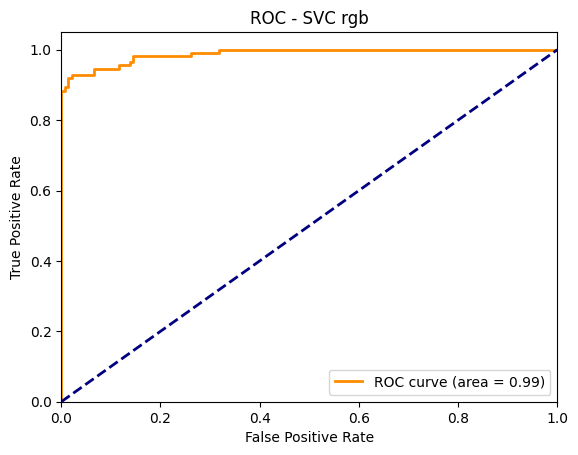

In [11]:
y_scores = svm_model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - SVC '+ mode)
plt.legend(loc="lower right")
plt.show()

# Save and load the model

In [32]:
model_name = "svm_model"
joblib.dump(svm_model, f"{model_name}.pkl")
loaded_model = joblib.load(f"{model_name}.pkl")

# Visualize the results

In [25]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

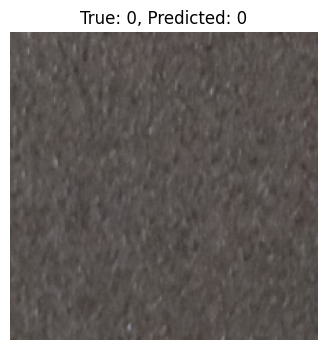

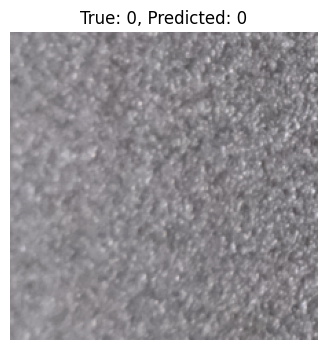

In [29]:
num_pics = 2
y_pred = svm_model.predict(X_test)

for idx, (image, label) in enumerate(train_loader.dataset):
    if idx >= num_pics:
        break
    true_label = y_test[idx]
    predicted_label = y_pred[idx]
    image_np = image.permute(1, 2, 0).numpy()
    image_np = (image_np * 0.5) + 0.5
    plt.figure(figsize=(4, 4))
    plt.imshow(image_np.squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.show()


# Heatmap visualization

In [30]:
class FeatureHeatmapGenerator:
    def __init__(self, model, svm_weights):
        self.model = model
        self.svm_weights = svm_weights
        self.feature_maps = None
        self.model.layer3.register_forward_hook(self.save_feature_maps)

    def save_feature_maps(self, module, input, output):
        """Save the feature maps from the layer."""
        self.feature_maps = output.detach()

    def generate_heatmap(self, image_tensor):
        _ = self.model(image_tensor)
        feature_maps = self.feature_maps[0]
        heatmap = torch.zeros_like(feature_maps[0])
        for i, weight in enumerate(self.svm_weights):
            heatmap += feature_maps[i] * weight
        heatmap = torch.relu(heatmap)
        heatmap = heatmap.cpu().numpy()
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        return heatmap

In [43]:
def preprocess_image(image_path, mode="grayscale"):
    if mode == "grayscale":
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
        image = Image.open(image_path).convert("L")
        image = transform(image)
        image = image.repeat(3, 1, 1)
    elif mode == "rgb":
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image = Image.open(image_path).convert("RGB")
        image = transform(image)
    else:
        raise ValueError("Unsupported mode. Use 'grayscale' or 'rgb'.")
    return image.unsqueeze(0)

In [35]:
def overlay_heatmap(image_path, heatmap, mode="rgb"):
    if mode == "grayscale":
        img = np.array(Image.open(image_path).convert("L")) / 255.0
    elif mode == "rgb":
        img = np.array(Image.open(image_path).convert("RGB")) / 255.0
    else:
        raise ValueError("Unsupported mode. Use 'grayscale' or 'rgb'.")
    heatmap_resized = np.array(
        Image.fromarray((heatmap * 255).astype(np.uint8)).resize(img.shape[:2][::-1], resample=Image.BILINEAR)
    ) / 255.0
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
    if mode == "grayscale":
        overlay = (np.stack([img] * 3, axis=-1) * 0.6) + (heatmap_colored * 0.4)
    elif mode == "rgb":
        overlay = (img * 0.6) + (heatmap_colored * 0.4)
    overlay = (overlay * 255).astype(np.uint8)
    return overlay

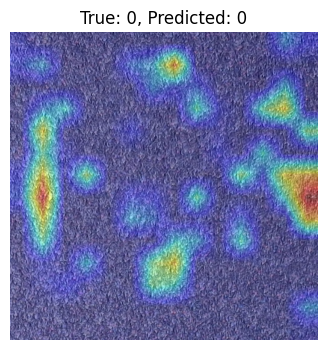

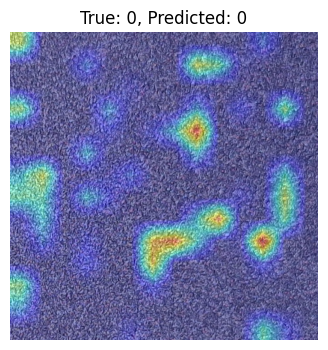

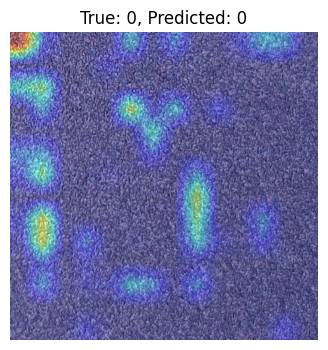

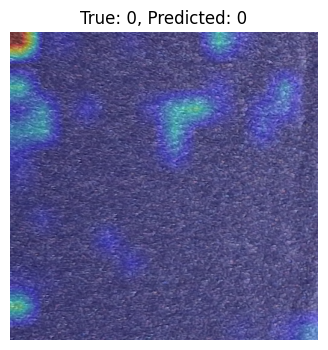

In [59]:
# Generate heatmaps for the first few test images
num_pics = 4
svm_weights = svm_model.coef_[0]
svm_weights = svm_weights / np.linalg.norm(svm_weights)
for idx, (image, label) in enumerate(test_loader.dataset):
    if idx >= num_pics:
        break
    image_path = test_loader.dataset.imgs[idx][0]
    image_tensor = preprocess_image(image_path, mode).to(device)
    heatmap_generator = FeatureHeatmapGenerator(resnet50, svm_weights)
    heatmap = heatmap_generator.generate_heatmap(image_tensor)
    overlay_image = overlay_heatmap(image_path, heatmap, mode=mode)
    original_image = np.array(Image.open(image_path).convert("L" if mode == "grayscale" else "RGB"))
    plt.figure(figsize=(4, 4))
    plt.imshow(overlay_image)
    plt.axis("off")
    plt.title(f"True: {label}, Predicted: {y_pred[idx]}")
    plt.show()